In [ ]:
# Importa las librerias necesarias

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:

# 1. Se Genera la serie de tiempo arbitraria [Simulación de ventas de un comercio]
np.random.seed(14)
time = np.arange(0, 700, 1)
data = np.sin(0.1 * time) + 0.05 * time + np.random.normal(0, 0.2, 700) #Para la estacionalidad [variabilidad de las ventas] y para la tendencia del negocio
data = data.reshape(-1, 1)

# 2. Normalización (Escalar entre 0 y 1)
scaler = MinMaxScaler(feature_range=(0, 1)) #Para transformar todo al rango [0,1] especialmente ventas altas
scaled_data = scaler.fit_transform(data)

# 3. Crear secuencias (Ventana de tiempo)
# Usaremos los últimos 10 días para predecir el siguiente
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, 0])
        y.append(data[i+window, 0])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(scaled_data, window_size)

# Reshape para LSTM: [muestras, pasos_de_tiempo, características]
X = X.reshape((X.shape[0], X.shape[1], 1))

# División entrenamiento/prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
def build_model(config='A'):
    model = Sequential()
    if config == 'A':
        model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
        model.add(Dense(1))
    else:
        # Para apilar LSTMs, la primera debe tener return_sequences=True
        model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(window_size, 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(50, activation='relu'))
        model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    return model

# Entrenar ambos modelos
model_a = build_model('A')
model_b = build_model('B')

print("--- Resumen Modelo A (Simple) ---")
model_a.summary()
history_a = model_a.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

print("\n--- Resumen Modelo B (Profundo) ---")
model_b.summary()
history_b = model_b.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

--- Resumen Modelo A (Simple) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)


--- Resumen Modelo B (Profundo) ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


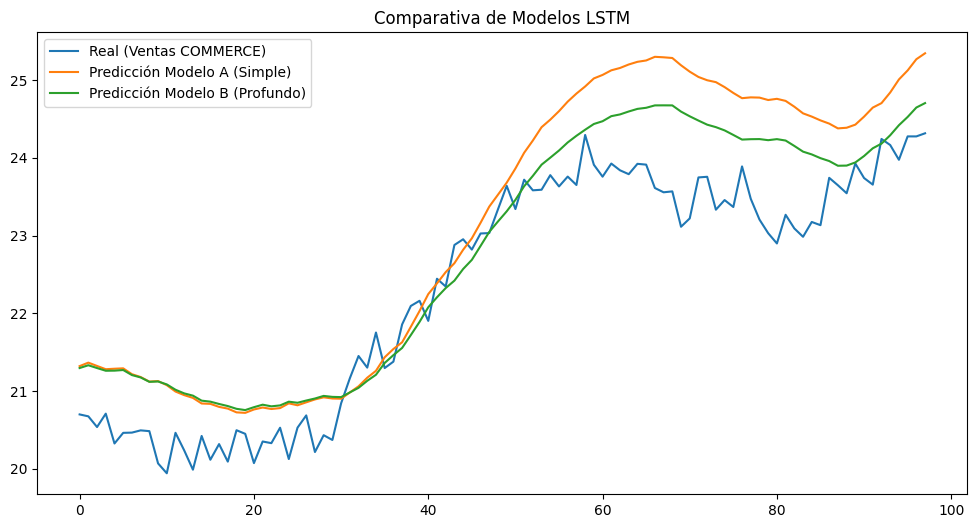

In [ ]:
# Predicciones
pred_a = model_a.predict(X_test)
pred_b = model_b.predict(X_test)

# Revertir el escalado para comparar con datos reales
pred_a = scaler.inverse_transform(pred_a)
pred_b = scaler.inverse_transform(pred_b)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Real (Ventas COMMERCE)')
plt.plot(pred_a, label='Predicción Modelo A (Simple)')
plt.plot(pred_b, label='Predicción Modelo B (Profundo)')
plt.legend()
plt.title("Comparativa de Modelos LSTM")
plt.show()